In [1]:
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [26]:
import argparse
from collections import defaultdict
import difflib
import json
import os
import pickle
import re
import sys

from datasets import load_dataset
from dotenv import load_dotenv
import inflect
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from evolution import ArchiveGame, SelectedConceptArchive, ConceptPCAArchive
from fitness_helpers import FITNESS_METRIC_KEYS
from java_api import Novelty
from java_helpers import SEMANTIC_BEHAVIORAL_CHARACTERISTICS, SYNTACTIC_BEHAVIORAL_CHARACTERISTICS

In [27]:
DATA_DIR = '../exp_outputs'
valid_dirs = list(sorted([path for path in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, path))]))
dropdown = widgets.Dropdown(
    options=valid_dirs,
    description='Experiment directory:',
    disabled=False,
    style={'description_width': 'initial'}
)
dropdown

Dropdown(description='Experiment directory:', options=('evaluations', 'feb_24_full_run', 'feb_25_full_run', 'm…

In [28]:
selected_path = os.path.join(DATA_DIR, dropdown.value)

In [29]:
run_args = argparse.Namespace() 
run_args.__dict__ = json.load(open(os.path.join(selected_path, "run_args.json"), "r"))

# Load run stats JSON into dataframe
run_stats = pd.read_json(os.path.join(selected_path, 'run_stats.json'))

# Load the final archive state
last_epoch = -1
for path in os.listdir(selected_path):
    if path.startswith('archive'):
        epoch = int(path.split('_')[1].split('.')[0])
        if epoch > last_epoch:
            last_epoch = epoch

print(f"Loading archive from epoch {last_epoch}...")
with open(os.path.join(selected_path, f'archive_{last_epoch}.pkl'), 'rb') as f:
    archive = pickle.load(f)

Loading archive from epoch 900...


In [30]:
print(f"Loading dataset used during training...")
dataset_train = load_dataset(run_args.model_name + '-base-data', split='train', token=os.environ['HF_TOKEN'])
dataset_val = load_dataset(run_args.model_name + '-base-data', split='val', token=os.environ['HF_TOKEN'])
dataset_test = load_dataset(run_args.model_name + '-base-data', split='test', token=os.environ['HF_TOKEN'])

print(f"Initializing dummy archive with correct behavioral characteristics...")
# Create the archive
if run_args.archive_type == "selected_concept":

    # Determine the behavioral characteristics to use
    if run_args.bc_type == "syntactic":
        bc_concepts = SYNTACTIC_BEHAVIORAL_CHARACTERISTICS
    elif run_args.bc_type == "semantic":
        bc_concepts = SEMANTIC_BEHAVIORAL_CHARACTERISTICS
    elif run_args.bc_type == "combined":
        bc_concepts = SYNTACTIC_BEHAVIORAL_CHARACTERISTICS + SEMANTIC_BEHAVIORAL_CHARACTERISTICS
    else:
        raise ValueError(f"Behavioral characteristic type {run_args.bc_type} not recognized")
    
    dummy_archive = SelectedConceptArchive(bc_concepts, run_args.entries_per_cell)

elif run_args.archive_type == "pca":
    dummy_archive = ConceptPCAArchive(only_boolean=not run_args.use_all_concepts,
                                      pca_dims=run_args.pca_dims,
                                      cells_per_dim=run_args.cells_per_dim,
                                      dim_extents=run_args.dim_extents,
                                      entries_per_cell=run_args.entries_per_cell,
                                      cache_dir="../caches")

train_cells = set([dummy_archive._get_cell(ArchiveGame(game['base_game'], [], [], [], 0, game['name'])) for game in tqdm(dataset_train, desc="Determinings cells for training games")])
val_cells = set([dummy_archive._get_cell(ArchiveGame(game['base_game'], [], [], [], 0, game['name'])) for game in tqdm(dataset_val, desc="Determinings cells for validation games")])
test_cells = set([dummy_archive._get_cell(ArchiveGame(game['base_game'], [], [], [], 0, game['name'])) for game in tqdm(dataset_test, desc="Determinings cells for testing games")])

occupied_cells = {
    'train': train_cells,
    'val': val_cells,
    'test': test_cells,
    'any': train_cells.union(val_cells).union(test_cells)
}

Loading dataset used during training...
Initializing dummy archive with correct behavioral characteristics...


Determinings cells for testing games: 100%|██████████| 72/72 [00:09<00:00,  7.53it/s]


In [39]:
# For each split / all splits combined, contains all games which aren't in cells covered by that split
novel_cells = defaultdict(list)
for cell, games in archive.items():
    for split in ['train', 'val', 'test', 'any']:
        if cell not in occupied_cells[split]:
            novel_cells[split].append(cell)

novel_games = sum([archive[cell] for cell in novel_cells['any']], [])

for split in ['train', 'val', 'test', 'any']:
    print(f"There are {len(novel_cells[split])} occupied cells in the archive not covered by {split} split")

There are 163 occupied cells in the archive not covered by train split
There are 290 occupied cells in the archive not covered by val split
There are 295 occupied cells in the archive not covered by test split
There are 146 occupied cells in the archive not covered by any split


Text(0.5, 1.0, 'Fitness distribution of novel games')

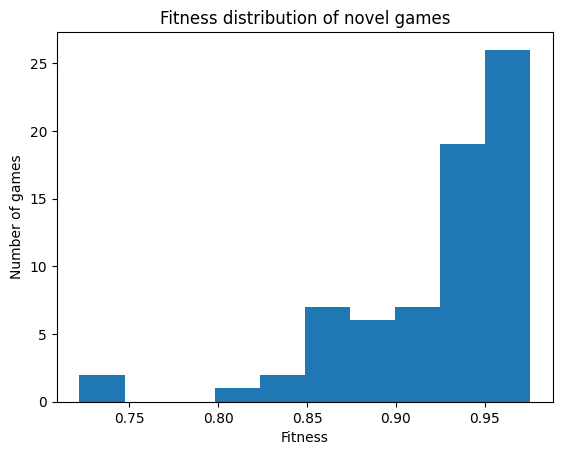

In [33]:
# Histogram of fitness values
fitnesses = [game.fitness_score for game in novel_games if game.fitness_score >= 0]
plt.hist(fitnesses, bins=10)
plt.xlabel("Fitness")
plt.ylabel("Number of games")
plt.title("Fitness distribution of novel games")

Text(0.5, 1.0, 'Fitness metric distribution of novel games')

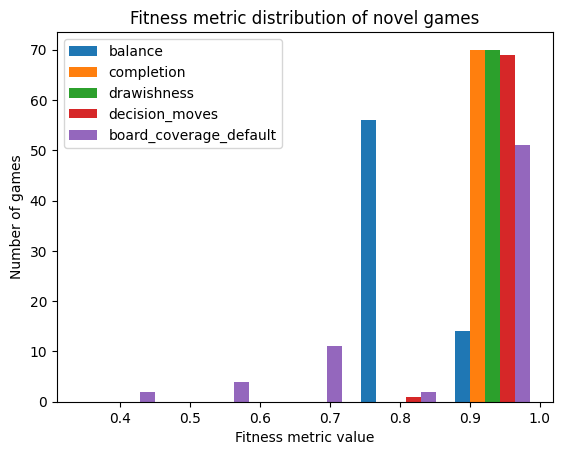

In [34]:
# Simulataneous histogram of each of the fitness metrics on a single plot
fitness_metrics = {key: [game.evaluation[key] for game in novel_games if game.fitness_score >= 0] for key in FITNESS_METRIC_KEYS if key != "mean_turns"}
fig, ax = plt.subplots()
ax.hist(fitness_metrics.values(), bins=5, label=list(fitness_metrics.keys()))
ax.legend()
plt.xlabel("Fitness metric value")
plt.ylabel("Number of games")
plt.title("Fitness metric distribution of novel games")

In [40]:
print("Loading novelty evaluator...")
novelty = Novelty()
novelty.load_game_library(dataset_train['base_game'] + dataset_val['base_game'] + dataset_test['base_game'])

Loading novelty evaluator...


KeyboardInterrupt: 